#1. Introduction:

* **This Notebook is based on the implementation of Veracity prediction(Sentence Classification) of health claims. Veracity Prediction output probability of input clam that belong to one of four classes: true, false, unproven, mixture.**

* **As the dataset is based on public health claims (bio, disease, scientific terms) we are using Sci-BERT for veracity prediction.[Scibert](https://github.com/allenai/scibert)**

In [ ]:
# Checking GPU
!nvidia-smi  

Sun Jul 18 18:08:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#2. Install Libraries:

Here we are using pytorch-lightning for faster training and reproducibility.

In [ ]:
%%capture 
!pip install --quiet sentence-transformers
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import nltk
#nltk.download('punkt')
 
# Necessary Libraries 
import re # Regular expression
import string
import random # pick random samples
import transformers # HuggingFace Transformers 
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader # Pytorch dataset and Dataloader for Data building for model
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification # Generic tokenizer class ,Generic model class, Model Class with a sequence classification head
from transformers import get_scheduler
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import pytorch_lightning as pl # pytorch lightning wrapper
from pytorch_lightning.metrics.functional import accuracy, f1, auroc # Inbild metrics of pl 
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping # For model saving and reusability
from sentence_transformers import SentenceTransformer, util
from pytorch_lightning.loggers import TensorBoardLogger # For visualization of metrics in TensorBoard
 
# Ploting and Visualization
import seaborn as sns   
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [ ]:
# Getting tokenizer 
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# 3. Download the Dataset:
### You can grab the Dataset from our repo or you can download the dataset from Huggiface Dataset also [Link](https://huggingface.co/datasets/viewer/?dataset=health_fact).
 
Note📒: We are just using the preprocessed  data, where we only consider the top_k (k = 5) sentences from the maintext or we can say evidences along with the cliam text.

In [ ]:
!wget https://raw.githubusercontent.com/saswat01/Reproduce-Health_Fact_Checking/main/data/processed/pubhealth_train.csv
!wget https://raw.githubusercontent.com/saswat01/Reproduce-Health_Fact_Checking/main/data/processed/pubhealth_val.csv
!wget https://raw.githubusercontent.com/saswat01/Reproduce-Health_Fact_Checking/main/data/processed/pubhealth_test.csv

--2021-07-18 18:08:50--  https://raw.githubusercontent.com/saswat01/Reproduce-Health_Fact_Checking/main/data/processed/pubhealth_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13115730 (13M) [text/plain]
Saving to: ‘pubhealth_train.csv’

pubhealth_train.csv 100%[===================>]  12.51M  67.9MB/s    in 0.2s    

2021-07-18 18:08:51 (67.9 MB/s) - ‘pubhealth_train.csv’ saved [13115730/13115730]

--2021-07-18 18:08:51--  https://raw.githubusercontent.com/saswat01/Reproduce-Health_Fact_Checking/main/data/processed/pubhealth_val.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conn

In [ ]:
# Reading data in PandasDataFrame
train = pd.read_csv('pubhealth_train.csv') # Training Data
validation = pd.read_csv('pubhealth_val.csv') # Validation Data
test = pd.read_csv('pubhealth_test.csv') # Test Data

train["index"] = train["Unnamed: 0"]
validation["index"] = validation["Unnamed: 0"]
test["index"] = test["Unnamed: 0"]

train.drop(columns=["Unnamed: 0","Unnamed: 0.1"],inplace=True)
validation.drop(columns=["Unnamed: 0","Unnamed: 0.1"],inplace=True)
test.drop(columns=["Unnamed: 0","Unnamed: 0.1"],inplace=True)
train.head() # Viewing top samples

,claim,top_k,label,explanation,index
0,"""The money the Clinton Foundation took from fr...",Some libertarian-minded constitutional law exp...,false,"""Gingrich said the Clinton Foundation """"took m...",0
1,Annual Mammograms May Have More False-Positives,4) Screening mammography recall rates are infl...,mixture,This article reports on the results of a study...,1
2,SBRT Offers Prostate Cancer Patients High Canc...,The real question is how do these harms compar...,mixture,This news release describes five-year outcomes...,2
3,"Study: Vaccine for Breast, Ovarian Cancer Has ...","Because of his competing research, he seems to...",true,"While the story does many things well, the ove...",3
4,Some appendicitis cases may not require ’emerg...,The focus of the story was on a study comparin...,true,We really don’t understand why only a handful ...,4


In [ ]:
validation.head(2)

,claim,top_k,label,explanation,index
0,A baby died at an unnamed medical facility be...,"Did the incident occur on 8 November 2015, the...",unproven,Fellow Twitter users suggested @FierceFemtivis...,0
1,Bat from Shawnee County tests positive for rab...,Symptoms include general weakness or discomfor...,true,A bat found in northeastern Kansas has tested ...,1


In [ ]:
test.head(2)

,claim,top_k,label,explanation,index
0,A mother revealed to her child in a letter aft...,"And I asked her, “who are you? I screamed at h...",false,The one-eyed mother story expounds upon two mo...,0
1,Study says too many Americans still drink too ...,"""There are people who don't realize that they ...",true,"On any given day in the United States, 18 perc...",1


In [ ]:
train.top_k[18]

'The article appears under the BBC’s ""England"" tab. The post was flagged as part of Facebook’s efforts to combat false news and misinformation on its News Feed. (Read more about our partnership with Facebook.) ""Ghislaine Maxwell moved to intensive care as coronavirus symptoms worsen,"" the headline says above an image of Maxwell. According to official autopsy results, Epstein killed himself last year in a New York jail cell where he was being held on federal sex trafficking charges, though conspiracy theories allege he was murdered because he had damaging information about powerful people.'

In [ ]:
validation.top_k[0]

'Did the incident occur on 8 November 2015, the date the tweets were posted, or earlier? What was the condition\xa0and ultimate\xa0cause of death? Readers were left with a number of questions when @FierceFemtivist deleted her account (and along with it, the controversial tweets). Were police summoned to investigate the baby’s death? According to @FierceFemtivist, she “just had an infant die” that she personally “could’ve saved” because the child’s epithet-slinging, Confederate flag-bedecked father purportedly physically blocked the nurse from entering the baby’s room despite the fact that the infant\xa0was “crashing fast.” @FierceFemtivist claimed to be the most qualified caregiver in the facility but did not provide a date, facility name, medical condition, nor even a gender for the baby who purportedly died solely because\xa0it had racist parents.'

In [ ]:
test.top_k[14]

'Republican House Leader and gubernatorial candidate Ken Fredette claims Democrats are now rushing to increase state spending and grow government. Democratic House Speaker Sara Gideon says Maine’s fiscal health is only as meaningful as the health of its people at a time of an opioid epidemic and a workforce shortage. Republicans are praising conservative fiscal policies and the elimination of a voter-approved surtax on the wealthy. Lawmakers consider spending, saving $128.5 million surplus. Democratic Rep. Drew Gattine says the surplus is a chance for a serious discussion about addressing issues like access to health care after voters approved Medicaid expansion in November.'

# Text Preprocessing :
* As we are working on a sequence classification problem  we can remove some noise from text.  


In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [ ]:
train['clean_top_k'] = train['top_k'].apply(lambda x:clean_text(x)) #Apply text preprocessing 
train['Length'] = train.top_k.str.len()
train['Word_count'] = train['top_k'].str.split().map(len)

validation['clean_top_k'] = validation['top_k'].apply(lambda x:clean_text(x))
validation['Length'] = validation.top_k.str.len()
validation['Word_count'] = validation['top_k'].str.split().map(len)


test['clean_top_k'] = test['top_k'].apply(lambda x:clean_text(x))
test['Length'] = test.top_k.str.len()
test['Word_count'] = test['top_k'].str.split().map(len)

In [ ]:
train.head(10)

,claim,top_k,label,explanation,index,clean_top_k,Length,Word_count
0,"""The money the Clinton Foundation took from fr...",Some libertarian-minded constitutional law exp...,false,"""Gingrich said the Clinton Foundation """"took m...",0,Some libertarianminded constitutional law expe...,668,102
1,Annual Mammograms May Have More False-Positives,4) Screening mammography recall rates are infl...,mixture,This article reports on the results of a study...,1,Screening mammography recall rates are influe...,479,73
2,SBRT Offers Prostate Cancer Patients High Canc...,The real question is how do these harms compar...,mixture,This news release describes five-year outcomes...,2,The real question is how do these harms compar...,692,114
3,"Study: Vaccine for Breast, Ovarian Cancer Has ...","Because of his competing research, he seems to...",true,"While the story does many things well, the ove...",3,Because of his competing research he seems to ...,590,101
4,Some appendicitis cases may not require ’emerg...,The focus of the story was on a study comparin...,true,We really don’t understand why only a handful ...,4,The focus of the story was on a study comparin...,457,79
5,Britain to reveal trial criteria for coronavir...,"“If our test fails the validation, then it’s n...",true,British regulators will this week reveal appro...,5,“If our test fails the validation then it’s no...,920,154
6,Angioplasty through the wrist backed by new study,The story did not provide cost estimates for e...,true,This is a good piece of reporting about a rece...,6,The story did not provide cost estimates for e...,798,132
7,U.S. says results encouraging for healthcare d...,“It’s giving us great confidence that this is ...,true,The Obama administration on Thursday reported ...,7,“It’s giving us great confidence that this is ...,849,138
8,Latest trial in J&J talc litigations gets unde...,J&J in court filings in the Leavitt case said ...,true,A California jury on Monday heard opening stat...,8,JJ in court filings in the Leavitt case said t...,474,81
9,Poor test results for heart drugs,There was also no mention of the two accompany...,false,"""The story reports no additional cardiovascula...",9,There was also no mention of the two accompany...,421,67


#### Average sentence length in train data.

In [ ]:
sum(train.Word_count) /len(train)

119.05650178480367

In [ ]:
train.Word_count.sum(axis = 0, skipna = True) / len(train)

119.05650178480367

In [ ]:
train.columns

Index(['claim', 'top_k', 'label', 'explanation', 'index', 'clean_top_k',
       'Length', 'Word_count'],
      dtype='object')

In [ ]:
train.clean_top_k[8]

'JJ in court filings in the Leavitt case said that fibers found in the Korean talc or any of its other cosmetic talc could not be classified as asbestos and referred to them as nonasbestos forms that its experts say are harmless Both forms often occur together and in talc deposits The report prompted a stock selloff on fears of JJ’s liability Geologically some asbestos can occur as “nonasbestiform” rocks A lawyer for JJ will make his opening remarks on Tuesday'

#### **Checking the sentence length distribution**

* We'll pad the sentence which as longer than the max_length and add truncation also while doing tokenization process.



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


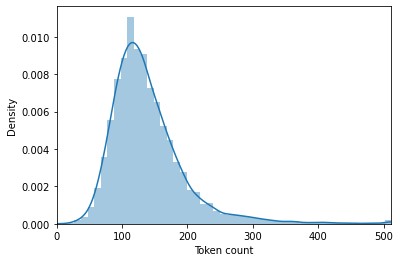

In [ ]:
token_lens = []
for txt in train.clean_top_k:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


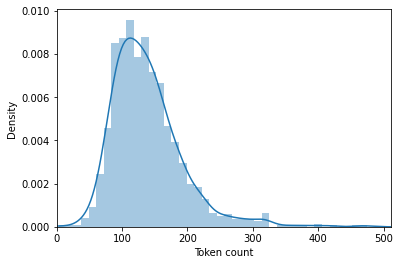

In [ ]:
token_lens = []
for txt in validation.clean_top_k:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

#### **Note📒: From the Above we find out that average length of the token is around 120 and few sentences have a length of 500 plus.**

In [ ]:
# Getting a single sample to check tokenization process
claim = train.iloc[12].claim
evidence = train.iloc[12].top_k

In [ ]:
input1 = tokenizer.encode_plus(claim+evidence, padding=True, truncation=True, return_tensors='pt')
# Viewing Tokenized Representation of one sample
input1

{'input_ids': tensor([[  102,  4559,  2985, 14643,  3814, 30118,   190,  2016,  6120, 16916,
         12126, 10996,   111,  8541,   131,  7939,  2296,   121,  1745,  4927,
           123,   145,  1471,  2761, 10424, 30107,   422, 29143, 24765,   422,
           137,  2206,  1594, 30126, 13896,  1525, 22856,   546,   220,  1427,
           168, 13543,   205,   256,  5459,   112,  1558,   627, 22914,   345,
           168,   111, 16124,   131,  1558,   627, 22914,   345,   205,   137,
           198,  5459,   112,   302,  1248,   627, 22914,   345,   205,   256,
         16167,   899,  4260,   205,   256,  5459,   112,   302,  5425, 20177,
           205,   256, 16167, 10954,   205,   103]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

#### **Converting the categorical targets to Numeric targets for simplicity.**

```
"label":[
0:"false"
1:"True"
2:"mixture"
3:"unproven"
]
```




In [ ]:
def to_sentiment(rating):
    rating = str(rating)
    if rating == 'false':
        return 0
    elif rating == 'mixture':
        return 2
    elif rating == 'true': 
        return 1
    else:
        return 3

train['label'] = train.label.apply(to_sentiment)
validation['label'] = validation.label.apply(to_sentiment)
test['label'] = test.label.apply(to_sentiment)

#### **Checking the class Distribution in the datset.**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


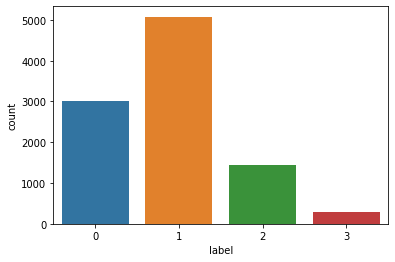

In [ ]:
sns.countplot(train["label"])

As you can see above there is a class imbalance problem present in the dataset. So we are using text augumentation to overcome the imbalance problem.

#4. Text Augumentation:
* Here we introduce text augumention to overcome the class imbalance problem.
* Uncomment and run the below cell to use augumentation.
* Here we use NLPAUG for Augumentation.


In [ ]:
# !pip install --quiet nlpaug
# import nlpaug.augmenter.char as nac
# import nlpaug.augmenter.word as naw
# import nlpaug.augmenter.sentence as nas
# import nlpaug.flow as nafc
# import nltk
# nltk.download('averaged_perceptron_tagger') 
# nltk.download('wordnet')

In [ ]:
# aug = naw.SynonymAug(aug_src='wordnet',aug_max=15)

In [ ]:
# def func(df):

#   augmented_sentences=[]
#   augmented_sentences_labels=[]

#   for i in range(len(df)):
#     row = df.iloc[i]
#     if row.label==3:
#       temps=aug.augment(str(row.top_k),n=7)
#       for sent in temps:
#         df2 = {'Unnamed: 0': 10001, 'claim': row.claim, 'top_k': sent, 'label': row.label, 'explanation': row.explanation}
#         df = df.append(df2, ignore_index = True)
  
#   augmented_sentences=[]
#   augmented_sentences_labels=[]

#   for i in range(len(df)):
#     # if count<=210:
#     row = df.iloc[i]
#     if row.label==2:
#       temps=aug.augment(str(row.top_k),n=1)
#       df2 = {'Unnamed: 0': 10001, 'claim': row.claim, 'top_k': temps, 'label': row.label, 'explanation': row.explanation}
#       df = df.append(df2, ignore_index = True)
#   return df

In [ ]:
# dummy_train = func(train)
# dummy_valid = func(validation)

In [ ]:
# dummy_train = dummy_train.sample(frac=1).reset_index(drop=True)
# dummy_valid = dummy_valid.sample(frac=1).reset_index(drop=True)

In [ ]:
# sns.countplot(dummy_train.label)

* Change train and validation data with dummy_train and dummy_valid to use augumentaion.

#5. Dataset Class:
#### Create a class to fetch the data in tokenized form. We need only Input_ids and Attention_mask from the Tokenizer to later feed into our model.

In [ ]:
class inputData(Dataset):
    def __init__(self, df):
        self.data = df
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #self.data = self.ranking(self.data)
        rows = self.data.iloc[idx] # Grab row wise
        claims = (str(rows.claim)).lower() # Convert to string and lower it
        evidences = (str(rows.clean_top_k)).lower() # Convert to string and lower it
        label = rows.label
        encoding = tokenizer.encode_plus(
            claims+evidences,  # Claim sample along with top 5 evidences 
            add_special_tokens=True,
            max_length=350, # Max length of input tokens
            return_token_type_ids=False, 
            padding='max_length', # If sentence is small padd upto max len i,e 512
            return_attention_mask=True, # Where to apply attention through out the sentence
            return_tensors='pt', # Retuen tensor for Pytorch
            truncation=True, # if sentence is long than max_len than truncation applied.
            )
        #return claims, evidences
        return dict(
            input_ids=encoding["input_ids"].flatten(),  # Tokenized inputs 
            attention_mask=encoding["attention_mask"].flatten(), # Attention mask for Tokenized inputs
            labels=torch.tensor(label, dtype=torch.long)
        ) 

#### Fitting data in PyTorch DataLoader

In [ ]:
train_data = inputData(train) 
train_loader = DataLoader(train_data, batch_size=13, shuffle=True, num_workers=2) 
val_data = inputData(validation)
val_loader = DataLoader(val_data, batch_size=13, shuffle=True,num_workers=2)
test_data = inputData(test)
test_loader = DataLoader(test_data)

In [ ]:
# next(iter(train_loader))

### We'll wrap our custom dataset into a [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html).
### A DataModule is simply a collection of a train_dataloader, val_dataloader(s), test_dataloader(s) along with the matching transforms and data processing/downloads.

In [ ]:
class veracityModule(pl.LightningDataModule):

  def __init__(self, train, test, val, batch_size=13):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train
    self.test_df = test
    self.val_df = val

  def setup(self, stage=None):
    self.train_dataset = inputData(
      self.train_df
    )

    self.test_dataset = inputData(
      self.test_df
    )

    self.val_dataset = inputData(
        self.val_df
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

### veracityModule encapsulates all data loading logic and returns the necessary data loaders. Let’s create an instance of our data module

In [ ]:
N_EPOCHS = 5
BATCH_SIZE = 13

data_module = veracityModule(
  train,
  test,
  validation,
  batch_size=BATCH_SIZE,
)

#6. Model:

### Our model will use a pre-trained BertModel and a linear layer to convert the BERT representation to a classification task. We’ll pack everything in a LightningModule.

In [ ]:
class veracityPreds(pl.LightningModule):
 
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.biobert = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
    self.drop = nn.Dropout(p=0.3) # Add dropout for regularization reduce overfitting 
    self.classifier = nn.Linear(self.biobert.config.hidden_size, n_classes) # A dense layer with 4 class output
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.CrossEntropyLoss() # because we have multiclass classification
 
  def forward(self, input_ids, attention_mask, labels=None):
    _, pooled_output = self.biobert(input_ids, attention_mask=attention_mask, return_dict=False) # pooler_output (torch.FloatTensor of shape (batch_size, hidden_size)) – Last layer hidden-state of the first token of the sequence (classification token) further processed by a Linear layer and a Tanh activation function.
    output = self.classifier(pooled_output)
    output = self.drop(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output 
    # Total loss as the sum of the masked language modeling loss and the next sequence prediction (classification) loss.

 
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
 
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
 
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
 
  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
 
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
 
 
  def configure_optimizers(self):
 
    optimizer = AdamW(self.parameters(), lr=1e-6)
    # Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, 
    #after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
 
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

* **A small snippet to show about scheduler concept.**
* **The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We’ll use the get_linear_schedule_with_warmup.**

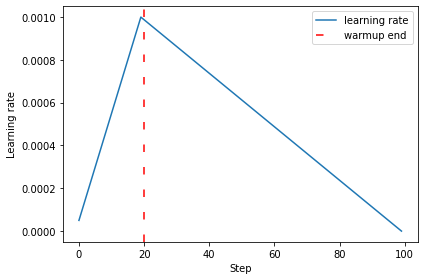

In [ ]:
dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 13
N_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss().to(device)
num_training_steps = N_EPOCHS * len(train_loader)
steps_per_epoch=len(train) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

cuda


* **Warm up steps is just a parameter in most of the learning algorithms which is used to lower the learning rate in order to reduce the impact of deviating the model from learning on sudden new data set exposure.**

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(754, 3770)

In [ ]:
model = veracityPreds(
  n_classes=4,
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

In [ ]:
#model

* Here we use TensorBoard to get metrics.

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="/content/Sci",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="Fact_check")

* **And early stopping triggers when the loss hasn’t improved for the last 2 epochs (you might want to remove/reconsider this when training on real-world projects)**

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2) # if loss drop consecutively for 2 epoch than model training will terminate and model'll be saved. 

In [ ]:
trainer = pl.Trainer(
  checkpoint_callback=checkpoint_callback,
  callbacks=[checkpoint_callback, early_stopping_callback],
  gpus=1,
  max_epochs=N_EPOCHS,
  progress_bar_refresh_rate=30
)

In [ ]:
trainer.fit(model, data_module)

In [ ]:
trainer.test(model) 

In [ ]:
class testInput(Dataset):
    def __init__(self, df):
        self.data = df
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #self.data = self.ranking(self.data)
        rows = self.data.iloc[idx]
        claims = (str(rows.claim)).lower()
        evidences = (str(rows.clean_top_k)).lower()
        label = rows.label
        encoding = tokenizer.encode_plus(
            claims,
            evidences,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
            )
        #return claims, evidences
        return dict(
            claims = claims,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.tensor(label, dtype=torch.long)
        )

In [ ]:
# device = 'cpu'

In [ ]:
from torch import nn
trained_model = veracityPreds.load_from_checkpoint('/content/drive/MyDrive/Sci/best-checkpoint.ckpt', n_classes=4)
trained_model.eval()
trained_model.freeze()

In [ ]:
# test_prediction

In [ ]:
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = trained_model.to(device)
val_dataset = inputData(test)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().to("cpu")  #cpu()
labels = torch.stack(labels).detach().to("cpu")       #cpu()

In [ ]:
accuracy(predictions, labels, threshold=0.5) 

tensor(0.6472)

In [ ]:
import torch.nn.functional as F 
from sklearn.metrics import f1_score, classification_report
print(classification_report(labels, torch.argmax(F.softmax(predictions, dim=1), dim=1)))

              precision    recall  f1-score   support

           0       0.53      0.81      0.64       388
           1       0.77      0.79      0.78       599
           2       0.47      0.03      0.06       201
           3       0.00      0.00      0.00        45

    accuracy                           0.65      1233
   macro avg       0.44      0.41      0.37      1233
weighted avg       0.62      0.65      0.59      1233



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


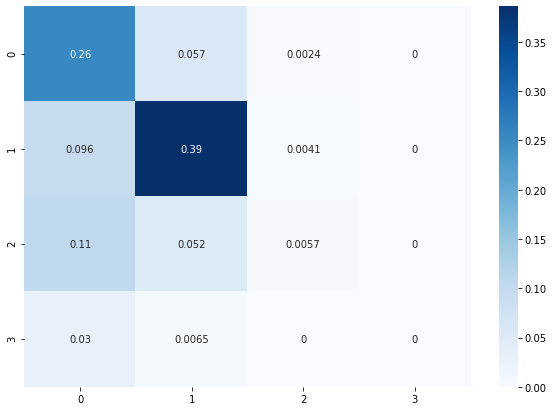

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
arr = confusion_matrix(labels, torch.argmax(F.softmax(predictions, dim=1), dim=1))
plt.figure(figsize = (10,7));
sns.heatmap(arr/np.sum(arr), annot=True, cmap='Blues');

# Prediction on test sample:

In [ ]:
test_sample = test.loc[test['label'] == 1]

In [ ]:
test_claim = test_sample.iloc[16].claim
test_evidence = test_sample.iloc[16].clean_top_k 
test_label = test_sample.iloc[16].label
print("Test Claim ------->\n",test_claim)
print("Test Evidence------>\n",test_evidence)
print("True Lable-------->\n", test_label)

encoding = tokenizer.encode_plus(
  test_claim+test_evidence,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

x, test_prediction = trained_model(encoding["input_ids"].to(device), encoding["attention_mask"].to(device))
test_prediction = test_prediction.flatten().detach().to("cpu").numpy()

# Prediction 
print("Predicted Label:",np.argmax(test_prediction))

Test Claim ------->
 Prince Harry joins Elton John to launch HIV campaign targeting men.
Test Evidence------>
 Speaking at the launch which also featured South African actress Charlize Theron and Ndaba Mandela the grandson of late President Nelson Mandela Elton John said “If we want to end AIDS once and for all we must make men part of the solution”  Around  million people around the world have HIV according to  figures cited by the United Nations’ HIVAIDS body UNAIDS UNAIDS said this month that the fight against HIVAIDS was “slipping off track” and while deaths were falling and treatment rates rising rates of new HIV infections threatened to derail efforts to defeat the disease “It is time there was a global coalition to teach men to protect themselves “MenStar” is supported by the US government’s PEPFAR program for tackling HIVAIDS and by the Bill and Melinda Gates Foundation Fewer than half of men living with HIV receive treatment compared with  percent of women it said
True Lable--

In [ ]:
# labels.shape

In [ ]:
# torch.argmax(F.softmax(predictions, dim=1), dim=1).shape

In [ ]:
review_text = test_sample.iloc[6].claim
review_top = test_sample.iloc[6].clean_top_k
review_label = test_sample.iloc[6].label

print(review_text)
print(review_top)
print(review_label)

Lawmakers consider spending, saving $128.5 million surplus.
Republican House Leader and gubernatorial candidate Ken Fredette claims Democrats are now rushing to increase state spending and grow government Democratic House Speaker Sara Gideon says Maine’s fiscal health is only as meaningful as the health of its people at a time of an opioid epidemic and a workforce shortage Republicans are praising conservative fiscal policies and the elimination of a voterapproved surtax on the wealthy Lawmakers consider spending saving  million surplus Democratic Rep Drew Gattine says the surplus is a chance for a serious discussion about addressing issues like access to health care after voters approved Medicaid expansion in November
1


In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text+review_top,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
    truncation=True,
    )


input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

class_names = ['false', 'true', 'mixture', 'unproven']

output = trained_model(input_ids, attention_mask)
prediction,_ = output

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
# import torch.nn.functional as F
# cnt = 0
# for i in test_loader:
#   if cnt<5:
#     input_id = i['input_ids']
#     att_mask = i['attention_mask']
#     out = trained_model(input_id, att_mask)
#     soft = F.softmax(out[1], dim=1)
#     print("Softmax output: ", soft)
#     print("Prediction: ", torch.argmax(soft, dim=1).item())
#     cnt+=1
#   else:
#     break

# Conclusion:

* Our Model properly generalize the True and False class, But its can poorly to generalize on the Mixture and Unproven Class.
* This is why we introduce use text Augumentation to overcome class imbalance probelm in NLP dataset.
* We tested the model on augumented data also and it generalize the Mixture and Unproven class a little bit better but the overall accuracy is decreasing. So we prefer to work on actutal data.
